# Import packages

In [2]:
from pathlib import Path
from typing import Iterable, List, Optional, Callable
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
import torch
from tqdm.auto import tqdm
import schedulefree
import segmentation_models_pytorch as smp
# from dvclive import Live
import torchseg
from flipnslide.tiling import FlipnSlide
from torchgeo.transforms import AugmentationSequential
from typing import Any
from torch import Tensor
import kornia as K

c:\ProgramData\Anaconda3\envs\erthy\Lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [1]:
%load_ext watermark
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [3]:
class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch=True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor (nSamples, Channels, Height, Width)
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input (with tiling applied to each sample)
        """
        n_samples, channels, height, width = input.shape
        # Prepare a list to store the transformed samples
        transformed_samples = []
        
        # Loop over each sample in the batch
        for sample in input:
            np_array = sample.cpu().numpy()  # Convert sample to NumPy format
            sample_tiled = FlipnSlide(
                tile_size=flags['tilesize'], 
                data_type='tensor',
                save=False, 
                image=np_array,
                viz=flags['viz']
            )
            # Collect the transformed sample (converted back to tensor)
            transformed_samples.append(sample_tiled.tiles.unsqueeze(0))

        transformed_samples = torch.cat(transformed_samples, dim=0)
        
        # Stack all transformed samples back into a batch
        return transformed_samples.view(-1, *transformed_samples.shape[2:])


In [4]:
# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize= 64, viz=False)
tfms = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

In [5]:
# Example usage
train_batch = {
    'image': torch.rand(3, 11, 256, 256),
    'mask': torch.rand(3, 1, 256, 256),
    'crs': [],
    'bbox': []
}
# batch_tfms = [tfms, tfms_img]
# if batch_tfms is not None:
#     transformed = [tfm(train_batch) for tfm in batch_tfms][0]
transformed = tfms(tfms_img(train_batch))

print("Transformed image shape:", transformed['image'].shape)
print("Transformed mask shape:", transformed['mask'].shape)

Transformed image shape: torch.Size([174, 13, 64, 64])
Transformed mask shape: torch.Size([174, 64, 64])


# Visualise a single image

In [6]:
from pathlib import  Path
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

# root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data")
root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN")
assert root.exists()

# train_imgs = list((root/'images').glob('*.tif'))
# train_masks = list((root/'masks').glob('*.tif'))
train_imgs = list((root/'train/X_chips').glob('*.tif'))
train_masks = list((root/'train/Y_chips').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()

In [7]:
idx = 11
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

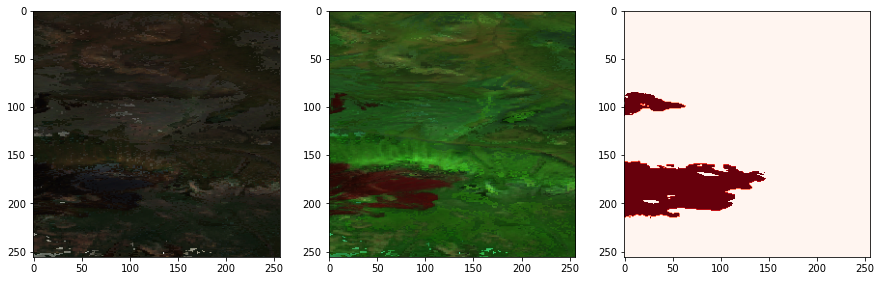

In [11]:
_, axs = plt.subplots(1, 3, figsize=(15, 6))

# plot the tile
FCI = [8, 6, 2]
TCI = [2, 1, 0]

rgb = img.data[TCI].transpose((1, 2, 0))*3#/17000
axs[0].imshow(rgb.clip(min=0, max=1))

rgb = img.data[FCI].transpose((1, 2, 0))*2#/25000
axs[1].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[2].imshow(mask.data.squeeze(), cmap='Reds')

In [12]:
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples

# train_ds = RasterDataset(paths=(root/'images').as_posix(), crs='epsg:4326', res= 0.00025)
train_ds = RasterDataset(paths=(root/'train/X_chips').as_posix(), crs='epsg:4326', res= 0.00025)

In [13]:
from torchgeo.samplers import RandomGeoSampler
sampler = RandomGeoSampler(train_ds, size= 64, length= 100)

In [14]:
# this is to get the same result in every pass
torch.manual_seed(0)

bbox = next(iter(sampler))
sample = train_ds[bbox]
print(sample.keys())
print(sample['image'].shape)

dict_keys(['crs', 'bbox', 'image'])
torch.Size([11, 64, 64])


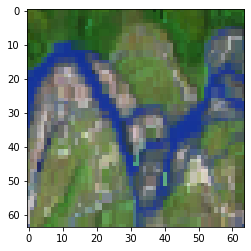

In [15]:
import matplotlib.pyplot as plt

arr = torch.clamp(sample['image'], min=0, max=1).numpy()
rgb = arr.transpose(2, 1, 0)[:, :, [8, 6, 2]]

plt.imshow(3*rgb.clip(min=0, max=1))

In [5]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

# Creating the datasets

In [1]:
import os
import shutil
import random
from tqdm.auto import tqdm

def split_data(root, image_folder, mask_folder, train_ratio=0.8, seed=None, fromRep=None, toRep=None):
    # Create train and test directories if they don't exist
    train_dir = os.path.join(root, 'train')
    test_dir = os.path.join(root, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Create image and mask folders within train and test directories
    train_image_dir = os.path.join(train_dir, 'images')
    train_mask_dir = os.path.join(train_dir, 'masks')
    test_image_dir = os.path.join(test_dir, 'images')
    test_mask_dir = os.path.join(test_dir, 'masks')
    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_mask_dir, exist_ok=True)
    os.makedirs(test_image_dir, exist_ok=True)
    os.makedirs(test_mask_dir, exist_ok=True)

    # Get list of TIFF image filenames
    image_filenames = [filename for filename in os.listdir(os.path.join(root, image_folder)) if filename.endswith('.tif')]

    # Set random seed for reproducibility
    random.seed(seed)

    # Randomly shuffle filenames
    random.shuffle(image_filenames)

    # Calculate number of samples for train and test
    num_samples = len(image_filenames)
    num_train_samples = int(num_samples * train_ratio)
    num_test_samples = num_samples - num_train_samples

    # Split images into train and test sets
    train_images = image_filenames[:num_train_samples]
    test_images = image_filenames[num_train_samples:]

    # Move images and masks to train and test directories
    for image_name in tqdm(train_images, desc='Moving train images and masks'):
        image_path = os.path.join(root, image_folder, image_name)
        mask_name = image_name.replace(fromRep, toRep)
        mask_path = os.path.join(root, mask_folder, mask_name)
        if os.path.exists(image_path) and os.path.exists(mask_path):
            shutil.move(image_path, os.path.join(train_image_dir, image_name))
            shutil.move(mask_path, os.path.join(train_mask_dir, mask_name))
        else:
            print(f"Either image {image_name} or mask {mask_name} does not exist.")

    for image_name in tqdm(test_images, desc='Moving test images and masks'):
        image_path = os.path.join(root, image_folder, image_name)
        mask_name = image_name.replace(fromRep, toRep)
        mask_path = os.path.join(root, mask_folder, mask_name)
        if os.path.exists(image_path) and os.path.exists(mask_path):
            shutil.move(image_path, os.path.join(test_image_dir, image_name))
            shutil.move(mask_path, os.path.join(test_mask_dir, mask_name))
        else:
            print(f"Either image {image_name} or mask {mask_name} does not exist.")

    print("Data split completed. Train samples:", num_train_samples, "Test samples:", num_test_samples)

# Example usage
dirname = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN"
split_data(dirname, 'X', 'Y', train_ratio=0.8, seed=42, fromRep='image_', toRep='label_')

Moving train images and masks:   0%|          | 0/531 [00:00<?, ?it/s]

Either image image_73.tif or mask label_73.tif does not exist.
Either image image_24.tif or mask label_24.tif does not exist.
Either image image_660.tif or mask label_660.tif does not exist.
Either image image_250.tif or mask label_250.tif does not exist.
Either image image_136.tif or mask label_136.tif does not exist.
Either image image_837.tif or mask label_837.tif does not exist.
Either image image_556.tif or mask label_556.tif does not exist.
Either image image_1098.tif or mask label_1098.tif does not exist.
Either image image_892.tif or mask label_892.tif does not exist.
Either image image_184.tif or mask label_184.tif does not exist.
Either image image_1050.tif or mask label_1050.tif does not exist.
Either image image_848.tif or mask label_848.tif does not exist.
Either image image_613.tif or mask label_613.tif does not exist.
Either image image_333.tif or mask label_333.tif does not exist.
Either image image_1399.tif or mask label_1399.tif does not exist.
Either image image_270.

Moving test images and masks:   0%|          | 0/133 [00:00<?, ?it/s]

Either image image_855.tif or mask label_855.tif does not exist.
Either image image_1111.tif or mask label_1111.tif does not exist.
Either image image_153.tif or mask label_153.tif does not exist.
Either image image_853.tif or mask label_853.tif does not exist.
Either image image_962.tif or mask label_962.tif does not exist.
Either image image_18.tif or mask label_18.tif does not exist.
Either image image_89.tif or mask label_89.tif does not exist.
Either image image_989.tif or mask label_989.tif does not exist.
Either image image_172.tif or mask label_172.tif does not exist.
Data split completed. Train samples: 531 Test samples: 133


In [1]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            # Replace inf with NaN
            bands_data[bands_data == np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\images"
process_images(directory)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\images"
process_images(directory)

Processing images:   0%|          | 0/765 [00:00<?, ?it/s]

Processing images:   0%|          | 0/124 [00:00<?, ?it/s]

In [1]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -2147483648] = 0
            
            # Update metadata
            profile = src.profile
            # profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\Y_chips"
process_images(directory)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\Y_chips"
process_images(directory)

Processing images:   0%|          | 0/1993 [00:00<?, ?it/s]

Processing images:   0%|          | 0/482 [00:00<?, ?it/s]

In [78]:
import os
import numpy as np
import rasterio
from tqdm.auto import tqdm

def find_non_zero_one_tiffs(folder_path):
    # List to store file names with non-zero or non-one pixel values
    non_zero_one_files = []
    max_values = []
    min_values = []

    # Iterate through all files in the folder
    for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith('.tif'):
            file_path = os.path.join(folder_path, file_name)
            
            # Open the raster file
            with rasterio.open(file_path) as src:
                # Read the data as a numpy array
                data = src.read()
                
                # Check for non-zero or non-one pixel values in the data
                if not np.allclose(data, 0) and not np.allclose(data, 1):
                    non_zero_one_files.append(file_name)
                
                # Find max values greater than 1
                max_values_greater_than_1 = data[data > 1]
                if max_values_greater_than_1.size > 0:
                    max_value = np.max(max_values_greater_than_1)
                    if not np.isnan(max_value):
                        max_values.append((file_name, max_value))
                
                # Find min values
                min_value = np.min(data)
                if not np.isnan(min_value):
                    min_values.append((file_name, min_value))

    # Print the list of files with non-zero or non-one pixel values
    print("Files with non-zero or non-one pixel values:")
    print(non_zero_one_files)

    # Print the list of max values greater than 1
    print("\nMax values greater than 1:")
    for file_name, max_value in max_values:
        print(f"{file_name}: {max_value}")

    # Print the list of min values
    print("\nMin values:")
    for file_name, min_value in min_values:
        print(f"{file_name}: {min_value}")

    # Compute the min and max of these lists
    if max_values:
        max_list = [max_value for _, max_value in max_values]
        print(f"\nMax of max values: {np.max(max_list)}")
        print(f"Min of max values: {np.min(max_list)}")

    if min_values:
        min_list = [min_value for _, min_value in min_values]
        print(f"\nMax of min values: {np.max(min_list)}")
        print(f"Min of min values: {np.min(min_list)}")

# Example usage
folder_path = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\Y_chips"
find_non_zero_one_tiffs(folder_path)


  0%|          | 0/1993 [00:00<?, ?it/s]

Files with non-zero or non-one pixel values:
['label_0_0_0.tif', 'label_1002_0_0.tif', 'label_1002_256_0.tif', 'label_1002_512_0.tif', 'label_1007_0_0.tif', 'label_100_0_256.tif', 'label_100_0_512.tif', 'label_100_1024_0.tif', 'label_100_1024_256.tif', 'label_100_1024_512.tif', 'label_100_1280_0.tif', 'label_100_1280_256.tif', 'label_100_1280_512.tif', 'label_100_256_256.tif', 'label_100_256_512.tif', 'label_100_512_0.tif', 'label_100_512_256.tif', 'label_100_512_512.tif', 'label_100_768_0.tif', 'label_100_768_256.tif', 'label_100_768_512.tif', 'label_1012_0_0.tif', 'label_1023_0_0.tif', 'label_1023_256_0.tif', 'label_1024_0_0.tif', 'label_1024_256_0.tif', 'label_1025_0_0.tif', 'label_1025_256_0.tif', 'label_1026_0_256.tif', 'label_1026_0_512.tif', 'label_1026_256_0.tif', 'label_1026_256_256.tif', 'label_1026_256_512.tif', 'label_1026_512_0.tif', 'label_1026_512_256.tif', 'label_1026_512_512.tif', 'label_1026_768_0.tif', 'label_1026_768_256.tif', 'label_1026_768_512.tif', 'label_1028_0

In [21]:
import os
import numpy as np
import rasterio
from tqdm.auto import tqdm

def find_inf_tiffs(folder_path):
    # List to store file names with inf or -inf values
    inf_files = []
    max_values = []
    min_values = []

    # Iterate through all files in the folder
    for file_name in tqdm(os.listdir(folder_path)):
        if file_name.endswith('.tif'):
            file_path = os.path.join(folder_path, file_name)
            
            # Open the raster file
            with rasterio.open(file_path) as src:
                # Read the data as a numpy array
                data = src.read()
                
                # Check for inf or -inf values in the data
                if np.isinf(data).any():
                    inf_files.append(file_name)
                
                # Find max values greater than 1
                max_values_greater_than_1 = data[data > 1]
                if max_values_greater_than_1.size > 0:
                    max_value = np.max(max_values_greater_than_1)
                    if not np.isnan(max_value):
                        max_values.append((file_name, max_value))
                
                # Find min values
                min_value = np.min(data)
                if not np.isnan(min_value):
                    min_values.append((file_name, min_value))

    # Print the list of files with inf or -inf values
    print("Files with inf or -inf values:")
    print(inf_files)

    # Print the list of max values greater than 1
    print("\nMax values greater than 1:")
    for file_name, max_value in max_values:
        print(f"{file_name}: {max_value}")

    # Print the list of min values
    print("\nMin values:")
    for file_name, min_value in min_values:
        print(f"{file_name}: {min_value}")

    # Compute the min and max of these lists
    if max_values:
        max_list = [max_value for _, max_value in max_values]
        print(f"\nMax of max values: {np.max(max_list)}")
        print(f"Min of max values: {np.min(max_list)}")

    if min_values:
        min_list = [min_value for _, min_value in min_values]
        print(f"\nMax of min values: {np.max(min_list)}")
        print(f"Min of min values: {np.min(min_list)}")

# Example usage
folder_path = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train\X"
find_inf_tiffs(folder_path)

  0%|          | 0/174 [00:00<?, ?it/s]

Files with inf or -inf values:
[]

Max values greater than 1:
image_0_0_0.tif: 1.7415872812271118
image_1006_0_0.tif: 1.740279197692871
image_1009_0_0.tif: 1.2276908159255981
image_1045_0_0.tif: 1.7415872812271118
image_105_0_0.tif: 1.513800024986267
image_107_0_0.tif: 1.2607775926589966
image_1090_0_0.tif: 1.1397377252578735
image_109_0_256.tif: 1.3542248010635376
image_1122_0_0.tif: 1.5191999673843384
image_1124_0_0.tif: 1.5184999704360962
image_1145_0_0.tif: 1.5321999788284302
image_1165_0_0.tif: 1.7168879508972168
image_1174_0_0.tif: 1.6929665803909302
image_1178_0_0.tif: 1.5305999517440796
image_117_0_0.tif: 1.2607775926589966
image_1187_0_0.tif: 1.6558057069778442
image_1197_0_0.tif: 1.1152000427246094
image_1205_0_0.tif: 1.1496552228927612
image_1207_0_0.tif: 1.0722999572753906
image_120_0_0.tif: 1.5190000534057617
image_1231_0_256.tif: 1.517699956893921
image_1233_0_0.tif: 1.1152000427246094
image_1280_0_0.tif: 1.6434507369995117
image_1324_0_256.tif: 1.1987279653549194
image_1

# Visualise batch data

In [23]:
from pathlib import Path
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data")
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()

train_imgs = RasterDataset(paths=(root/'train\X_chips').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\Y_chips').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False

In [24]:
sampler = RandomGeoSampler(train_imgs, size=256, length=2000, units=Units.PIXELS)
# let's get a random bounding box, just to check the datasets
bbox = next(iter(sampler))

img_sample = train_imgs[bbox]
msk_sample = train_msks[bbox]

print(img_sample.keys(), msk_sample.keys())

# let's assert the patches cover the same region...
print(img_sample['bbox'])
print(msk_sample['bbox'])
assert img_sample['bbox'] == msk_sample['bbox']

dict_keys(['crs', 'bbox', 'image']) dict_keys(['crs', 'bbox', 'mask'])
BoundingBox(minx=-118.90386266104407, maxx=-118.83986266104408, miny=36.605766440471, maxy=36.669766440471, mint=0.0, maxt=9.223372036854776e+18)
BoundingBox(minx=-118.90386266104407, maxx=-118.83986266104408, miny=36.605766440471, maxy=36.669766440471, mint=0.0, maxt=9.223372036854776e+18)


In [25]:
train_dset = train_imgs & train_msks

In [26]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [27]:
dataloader = DataLoader(train_dset, sampler=sampler, batch_size=8, collate_fn=stack_samples)

In [28]:
from typing import Iterable, List

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 1.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Reds')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [8, 6, 2]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

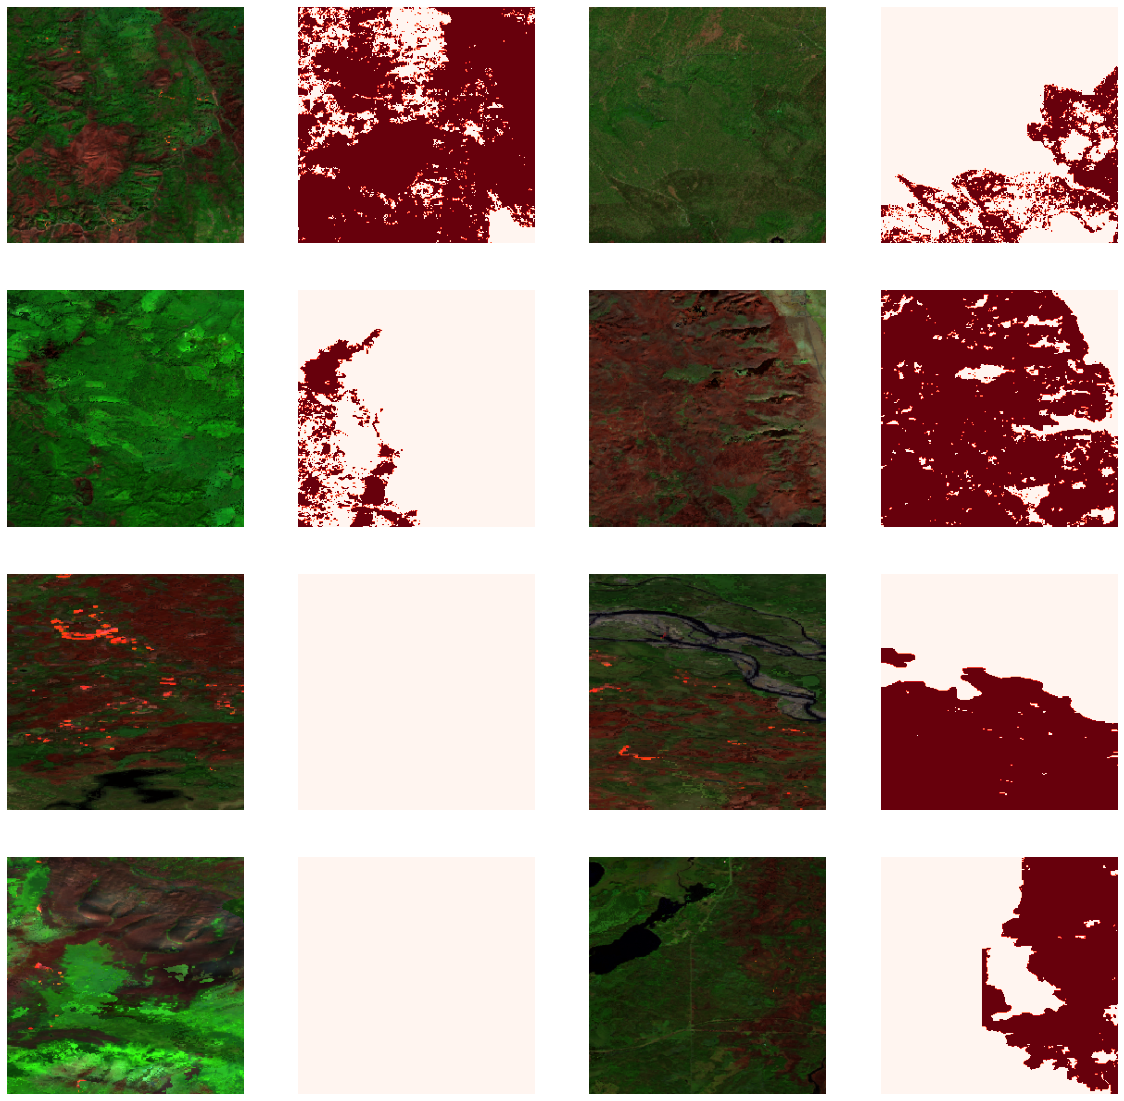

In [75]:
batch = next(iter(dataloader))
plot_batch(batch, 1.5)

In [76]:
from torchgeo.transforms import indices

ndwi_transform = indices.AppendNDWI(index_green=2, index_nir=4)

transformed_batch = ndwi_transform(batch['image'])
print(batch['image'].shape)
print(transformed_batch.shape)

torch.Size([8, 11, 256, 256])
torch.Size([8, 12, 256, 256])


# Pretraining

In [6]:
import torch
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
from torchgeo.transforms import AugmentationSequential

class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch=True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor (nSamples, Channels, Height, Width)
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input (with tiling applied to each sample)
        """
        n_samples, channels, height, width = input.shape
        # Prepare a list to store the transformed samples
        transformed_samples = []
        
        # Loop over each sample in the batch
        for sample in input:
            np_array = sample.cpu().numpy()  # Convert sample to NumPy format
            sample_tiled = FlipnSlide(
                tile_size=flags['tilesize'], 
                data_type='tensor',
                save=False, 
                image=np_array,
                viz=flags['viz']
            )
            # Collect the transformed sample (converted back to tensor)
            transformed_samples.append(sample_tiled.tiles.unsqueeze(0))

        transformed_samples = torch.cat(transformed_samples, dim=0)
        
        # Stack all transformed samples back into a batch
        return transformed_samples.view(-1, *transformed_samples.shape[2:])


# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=64, viz=False)

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
tfms_fns = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

# dataloader = DataLoader(train_dset, sampler=sampler, batch_size=1, collate_fn=stack_samples)
# batch = next(iter(dataloader))
# print(batch.keys())
# x = batch
# print(x['image'].shape)
# x = tfms_img(x)
# print(x['image'].shape)

# # print(tfms_both(x)['image'].shape)
# x = tfms_fns(x)
# print(x['mask'].unsqueeze(1).shape)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
model = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= 'imagenet',     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
)
model = model.to(device)

In [9]:
pred = model(torch.randn(3, 14, 64, 64, device = device))
pred.shape

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[3, 14, 64, 64] to have 3 channels, but got 14 channels instead

In [6]:
from typing import Dict 
import wandb

def train_loop(
    epochs: int,
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    train_tfms: Optional[Callable]=None,
    val_tfms: Optional[Callable]=None,
    train_params: Dict=None
):
    best_chkpt_score = float("-inf")
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")

        model.train()
        optimizer.train()
        accum_loss = 0
        
        with tqdm(total= len(train_dl), ascii=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

            for batch in train_dl:
                if train_tfms is not None:
                            # if multiple transforms, Apply transforms iteratively
                            if isinstance(train_tfms, list):
                                batch = [tfm(batch) for tfm in train_tfms][0]
                            else:
                                batch = train_tfms(batch)

                X = batch['image'].to(device)
                y = batch['mask'].type(torch.long).to(device)
                pred = model(torch.nan_to_num(X, nan = 0.0, posinf = 0.0, neginf = 0.0))
                loss = loss_fn(pred, y)
                
                # BackProp
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update the accum loss
                accum_loss += float(loss) / len(train_dl)
                
                pbar.set_postfix(loss=f"{accum_loss:.4f}")
                pbar.update(1)
        
        wandb.log({"train_loss": accum_loss})

        
        model.eval()
        optimizer.eval()
        accum_val_loss = 0
        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                with tqdm(total= len(val_dl), ascii=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

                    for batch in val_dl:

                        if val_tfms is not None:
                            # if multiple transforms, Apply transforms iteratively
                            if isinstance(val_tfms, list):
                                batch = [tfm(batch) for tfm in val_tfms][0]
                            else:
                                batch = val_tfms(batch)                    

                        X = batch['image'].type(torch.float32).to(device)
                        y = batch['mask'].type(torch.long).to(device)

                        pred = model(torch.nan_to_num(X, nan = 0.0, posinf = 0.0, neginf = 0.0))
                        val_loss = loss_fn(pred, y)
                        accum_val_loss += float(val_loss)/len(val_dl)

                        for i, acc_fn in enumerate(acc_fns):
                            acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))
                        
                        pbar.set_postfix(val_loss=f"{accum_val_loss:.4f}", val_acc=f"{acc[0]:.4f}", val_iou=f"{acc[1]:.4f}")
                        pbar.update(1)

        # Check if validation loss improved
        acc_fn = acc_fns[train_params.metric_index]
        chkpt_score = acc[i]
        if  chkpt_score > best_chkpt_score:
            best_chkpt_score = chkpt_score
            torch.save(model.state_dict(), train_params.save_model_path)
            print(f'Saving model with validation score: {best_chkpt_score:.4f} at epoch {epoch}')

        wandb.log({"val_loss": accum_val_loss, "val_acc": acc[0], "val_iou": acc[1]})
    wandb.finish()

        # with Live(save_dvc_exp=True) as live:
        #     for param_name, param_value in train_params.items():
        #         live.log_param(param_name, param_value)
        #     live.log_metric("model_saving_score", chkpt_score)
        #     live.log_metric("Train loss", accum_loss)
        #     live.log_metric("Val_loss", accum_val_loss)

In [7]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1., average='weighted')

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t)

In [8]:
from torchgeo.samplers import PreChippedGeoSampler
root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN")
train_imgs = RasterDataset(paths=(root/'train\X_chips').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\Y_chips').as_posix(), crs='epsg:4326', res= 0.00025)

valid_imgs = RasterDataset(paths=(root/'test\X_chips').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\Y_chips').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

# train_sampler = PreChippedGeoSampler(train_imgs)
# valid_sampler = PreChippedGeoSampler(valid_imgs)

train_sampler = RandomGeoSampler(train_imgs, size= 256, length = 1993, units=Units.PIXELS)#711#2136
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 482, units=Units.PIXELS)#178#496

train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size = 3, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 3, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

In [13]:
import os
import numpy as np
import rasterio
from tqdm.auto import tqdm

def find_bad_tif_files(images_folder):
    bad_files = []
    for filename in tqdm(os.listdir(images_folder)):
        if filename.endswith(".tif"):
            image_path = os.path.join(images_folder, filename)
            with rasterio.open(image_path) as src:
                width, height = src.width, src.height
                # Check if dimensions are incorrect
                if width != 256 or height != 256:
                    bad_files.append(filename)
                else:
                    # Check if more than 30% of pixels are NaN
                    img_array = src.read(1)
                    nan_percentage = np.isnan(img_array).mean() * 100
                    if nan_percentage > 30:
                        bad_files.append(filename)
    return bad_files

def delete_bad_images_and_labels(images_folder, masks_folder):
    bad_files = find_bad_tif_files(images_folder)
    
    for bad_image in bad_files:
        # Image path
        image_path = os.path.join(images_folder, bad_image)
        
        # Construct corresponding mask (label) path
        label_filename = bad_image.replace('image', 'label')
        label_path = os.path.join(masks_folder, label_filename)
        
        # Remove the bad image file
        if os.path.exists(image_path):
            os.remove(image_path)
            print(f"Deleted bad image: {image_path}")
        
        # Remove the corresponding label file
        if os.path.exists(label_path):
            os.remove(label_path)
            print(f"Deleted corresponding label: {label_path}")

# Directories for images and masks
images_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\X_chips'
masks_folder = r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\Y_chips'

# Delete bad images and their corresponding labels
delete_bad_images_and_labels(images_folder, masks_folder)

  0%|          | 0/1993 [00:00<?, ?it/s]

In [ ]:
# Initialize wandb
wandb.init(project="burn_area_mapping", name="DLconvnextv2", job_type='training p2')
# Define hyperparameters
config = wandb.config
config.learning_rate = 0.0025
config.epochs = 150
config.metric_index = 1
config.save_model_path = r"C:\Users\coach\myfiles\postdoc\Fire\models\DL_imgnet_convnextT_17102024p2.pth"

loss_fn = smp.losses.LovaszLoss(mode= 'multiclass')

# optimizer = torch.optim.Adam(model.parameters(), lr= train_params.get('lr'), weight_decay= train_params.get('weight_decay'))
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr= config.learning_rate)
train_loop(epochs = config.epochs, train_dl = train_dataloader, val_dl= valid_dataloader, model = model,
            loss_fn = loss, optimizer = optimizer, 
            acc_fns=[oa, iou], train_tfms= [tfms_img, tfms_fns], val_tfms = tfms_img, train_params = config)

# Plot predictions

In [3]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = smp.Unet(
#         encoder_name="resnet34",
#         encoder_weights= None,
#         in_channels=13,
#         classes=2,
#     ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")

model = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\Unet_convnextT_27092024.pth")

model = torchseg.DeepLabV3Plus(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    # decoder_channels=(256, 128, 64, 32),
    # head_upsampling=2                      
).to(device)
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DL_imgnet_convnextT_17102024p2.pth")


model.load_state_dict(checkpoint)
model.eval()

C:\Users\coach\AppData\Local\Temp\ipykernel_23376\4274808638.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fi

DeepLabV3Plus(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(14, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
   

In [5]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
valid_imgs = RasterDataset(paths=(root/'test\X_chips').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\Y_chips').as_posix(), crs='epsg:4326', res= 0.00025)
valid_dset = valid_imgs & valid_msks

# IMPORTANT
valid_msks.is_image = False
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 178, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)

In [6]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 5, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Predicted (argmax)',  'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
        mask = batch['mask'][idx].cpu().numpy()
        
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(out[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        # plot the reference mask
        axs[4].imshow(mask.squeeze(), cmap='Reds')
        axs[4].set_title(labels[4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


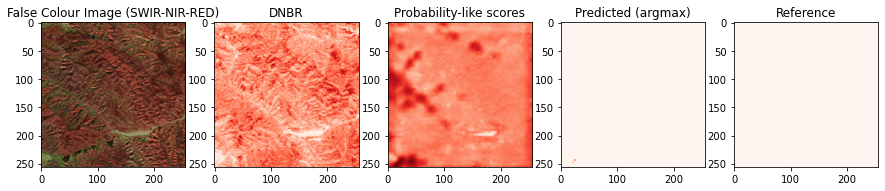

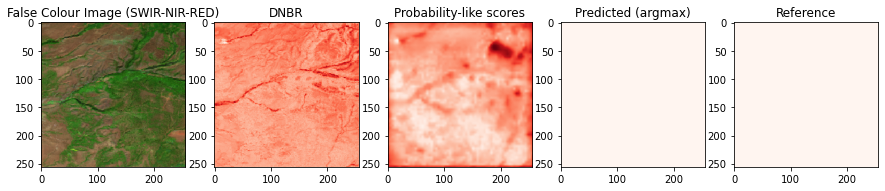

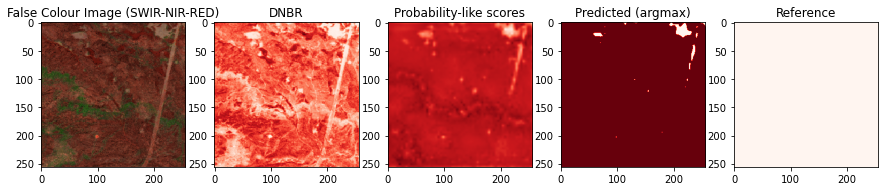

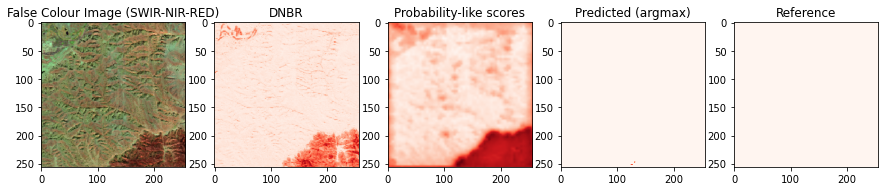

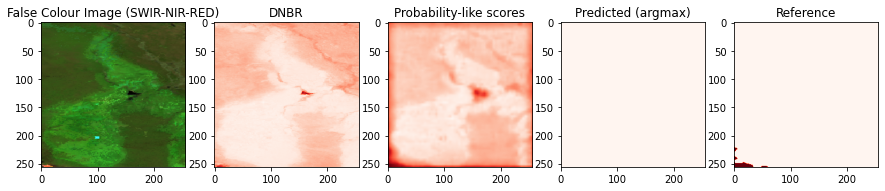

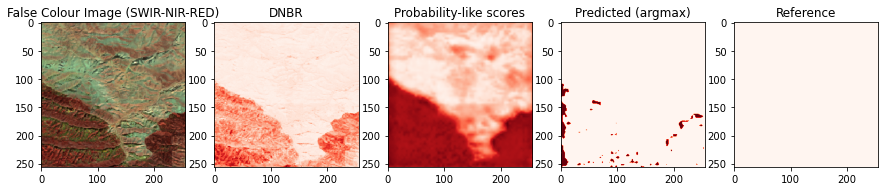

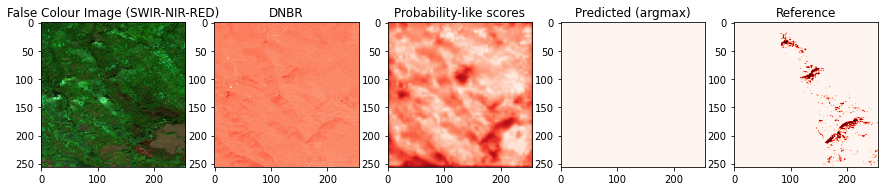

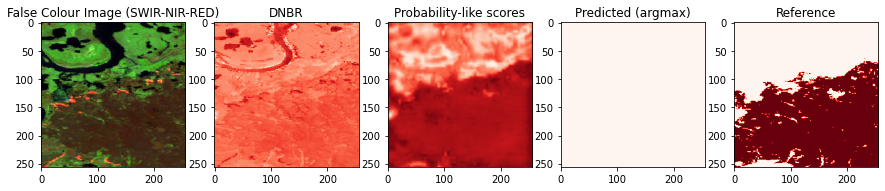

In [7]:
batch = next(iter(valid_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(torch.nan_to_num(inB))
plot_batch_preds(batch)

# SA Data

In [1]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\X_test"
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test\X"
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train\X"
process_images(directory)


Processing images:   0%|          | 0/17 [00:00<?, ?it/s]

In [4]:
import torch
import segmentation_models_pytorch as smp
import torchseg
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

modelunet = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)

# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")

modelunet = torchseg.DeepLabV3Plus(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    # decoder_channels=(256, 128, 64, 32),
    # head_upsampling=2                      
).to(device)
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DL_imgnet_convnextT_17102024p2.pth")

modelunet.load_state_dict(checkpoint)
modelunet.eval()

model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")

model.load_state_dict(checkpoint)
model.eval()

modelnxt = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\Unet_imgnet_convnextT_28092024.pth")

modelnxt.load_state_dict(checkpoint)
modelnxt.eval()

C:\Users\coach\AppData\Local\Temp\ipykernel_6040\3035608834.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fir

Unet(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(14, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            

In [10]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
test_sampler = RandomGeoSampler(test_imgs, size= 64, length = 178, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_imgs, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

In [11]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 6, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Pred (DLV3+)',  'Unet', 'Unet_nxt']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
                
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(outnxt[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        pred_mask = np.argmax(outunet[idx].detach().cpu().numpy(), axis=0)
        axs[4].imshow(pred_mask, cmap='Reds')
        axs[4].set_title(labels[4])

        pred_mask = np.argmax(outnxt[idx].detach().cpu().numpy(), axis=0)
        axs[5].imshow(pred_mask, cmap='Reds')
        axs[5].set_title(labels[5])

batch = next(iter(test_dataloader))
inB = tfms_img(batch)['image'].to(device)

out = model(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outunet = modelunet(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outnxt = modelnxt(inB)
plot_batch_preds(batch)

RuntimeError: Given groups=1, weight of size [96, 14, 4, 4], expected input[8, 13, 64, 64] to have 14 channels, but got 13 channels instead

# Finetuning

In [1]:
# Prepare data
import os
import shutil
import rasterio
from tqdm.auto import tqdm
import random

def copy_projection_and_sort(
    masks_folder: str, 
    images_folder: str, 
    train_folder: str, 
    test_folder: str, 
    test_ratio: float = 0.2
) -> None:
    """
    Copies projection information from images in `images_folder` to matching masks in `masks_folder` 
    based on matching names after the first underscore. Then, copies both masks and images to 
    train or test folders.

    Args:
        masks_folder (str): Path to the folder containing mask TIFF files.
        images_folder (str): Path to the folder containing image TIFF files.
        train_folder (str): Path to the folder where train images and masks will be stored.
        test_folder (str): Path to the folder where test images and masks will be stored.
        test_ratio (float, optional): Proportion of files to copy to the test folder. Defaults to 0.2.
    """
    # Ensure train and test folders exist for both X (images) and Y (masks)
    os.makedirs(os.path.join(train_folder, 'X'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'X'), exist_ok=True)
    os.makedirs(os.path.join(train_folder, 'Y'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'Y'), exist_ok=True)

    # List all mask files in the masks folder
    mask_files = [f for f in os.listdir(masks_folder) if f.endswith('.tif')]
    
    # Randomize the order of files to ensure better train-test split
    random.shuffle(mask_files)
    
    for mask_file in tqdm(mask_files, desc="Processing masks"):
        # Get the part of the mask filename after the first underscore
        mask_id = mask_file.split('_', 1)[1]

        # Try to find the corresponding image in the images folder
        matching_images = [f for f in os.listdir(images_folder) if mask_id in f]
        if not matching_images:
            print(f"No matching image found for {mask_file}. Skipping...")
            continue

        image_file = matching_images[0]  # Assuming the first match is the correct one

        # Read the projection information from the image file
        image_path = os.path.join(images_folder, image_file)
        mask_path = os.path.join(masks_folder, mask_file)

        with rasterio.open(image_path) as src_image:
            image_crs = src_image.crs
            image_transform = src_image.transform

        # Copy the mask file with updated projection information
        with rasterio.open(mask_path, 'r+') as dst_mask:
            dst_mask.crs = image_crs
            dst_mask.transform = image_transform

        # Determine if the file goes into train or test set based on test_ratio
        if random.random() < test_ratio:
            dest_folder = test_folder
        else:
            dest_folder = train_folder

        # Copy both the mask and the corresponding image to the destination folder
        shutil.copy(mask_path, os.path.join(dest_folder, 'Y', mask_file))
        shutil.copy(image_path, os.path.join(dest_folder, 'X', image_file))


# Example usage:
maskPath = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\irisLabels"
imagePath = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\X_chips"
trainFolder = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train"
testFolder = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test"
copy_projection_and_sort(maskPath, imagePath, trainFolder, testFolder, 0.15)

Processing masks:   0%|          | 0/202 [00:00<?, ?it/s]

In [2]:
import os
from pathlib import Path

def compare_and_delete_tif_images(directory, delete_unmatched=False):
    # Get the paths for subdirectories X and Y
    x_path = Path(directory) / 'X'
    y_path = Path(directory) / 'Y'
    
    # Check if both subdirectories exist
    if not (x_path.is_dir() and y_path.is_dir()):
        raise ValueError("Both subdirectories X and Y must exist in the given directory.")
    
    # Get lists of .tif files in both directories
    x_files = set(f.name for f in x_path.glob('*.tif'))
    y_files = set(f.name for f in y_path.glob('*.tif'))
    
    # Function to get the matching part of the filename
    def get_matching_part(filename):
        return '_'.join(filename.split('_')[1:])
    
    # Create sets of matching parts for both directories
    x_matching_parts = set(get_matching_part(f) for f in x_files)
    y_matching_parts = set(get_matching_part(f) for f in y_files)
    
    # Find unmatched files
    unmatched_x = [f for f in x_files if get_matching_part(f) not in y_matching_parts]
    unmatched_y = [f for f in y_files if get_matching_part(f) not in x_matching_parts]
    
    # Delete unmatched files if delete_unmatched is True
    if delete_unmatched:
        for file in unmatched_x:
            (x_path / file).unlink()
        for file in unmatched_y:
            (y_path / file).unlink()
        print(f"Deleted {len(unmatched_x)} unmatched files from X and {len(unmatched_y)} unmatched files from Y.")
    
    return {
        'unmatched_in_X': unmatched_x,
        'unmatched_in_Y': unmatched_y
    }

# Example usage:
root_dir = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train'
compare_and_delete_tif_images(root_dir, True)

root_dir = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test'
compare_and_delete_tif_images(root_dir, True)

Deleted 7 unmatched files from X and 15 unmatched files from Y.
Deleted 2 unmatched files from X and 3 unmatched files from Y.


{'unmatched_in_X': ['image_1118_0_0.tif', 'image_1124_0_0.tif'],
 'unmatched_in_Y': ['mask_118_0_0.tif',
  'mask_543_0_0.tif',
  'mask_124_0_0.tif']}

In [3]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\X_test"
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test\X"
process_images(directory)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train\X"
process_images(directory)

Processing images:   0%|          | 0/35 [00:00<?, ?it/s]

Processing images:   0%|          | 0/149 [00:00<?, ?it/s]

In [1]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from typing import Iterable, List, Optional, Callable

from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dvclive import Live
import torchseg

import schedulefree


c:\ProgramData\Anaconda3\envs\erthy\lib\site-packages\kornia\feature\lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
import torch
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
from torchgeo.transforms import AugmentationSequential

class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch=True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor (nSamples, Channels, Height, Width)
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input (with tiling applied to each sample)
        """
        n_samples, channels, height, width = input.shape
        # Prepare a list to store the transformed samples
        transformed_samples = []
        
        # Loop over each sample in the batch
        for sample in input:
            np_array = sample.cpu().numpy()  # Convert sample to NumPy format
            sample_tiled = FlipnSlide(
                tile_size=flags['tilesize'], 
                data_type='tensor',
                save=False, 
                image=np_array,
                viz=flags['viz']
            )
            # Collect the transformed sample (converted back to tensor)
            transformed_samples.append(sample_tiled.tiles.unsqueeze(0))

        transformed_samples = torch.cat(transformed_samples, dim=0)
        
        # Stack all transformed samples back into a batch
        return transformed_samples.view(-1, *transformed_samples.shape[2:])


# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=64, viz=False)

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
tfms_fns = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
modelunet = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
modelunet.load_state_dict(checkpoint)

model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")
model.load_state_dict(checkpoint)

model = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\Unet_imgnet_convnextT_28092024.pth")

model.load_state_dict(checkpoint)
model.eval()

model = torchseg.DeepLabV3Plus(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    # decoder_channels=(256, 128, 64, 32),
    # head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DL_imgnet_convnextT_17102024p2.pth")

model.load_state_dict(checkpoint)
model.eval()

C:\Users\coach\AppData\Local\Temp\ipykernel_5176\2262789107.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire

DeepLabV3Plus(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(14, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
   

In [4]:
from typing import Dict 
import wandb

def train_loop(
    epochs: int,
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    train_tfms: Optional[Callable]=None,
    val_tfms: Optional[Callable]=None,
    train_params: Dict=None
):
    best_chkpt_score = float("-inf")
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")

        model.train()
        optimizer.train()
        accum_loss = 0
        
        with tqdm(total= len(train_dl), ascii=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

            for batch in train_dl:
                if train_tfms is not None:
                            # if multiple transforms, Apply transforms iteratively
                            if isinstance(train_tfms, list):
                                batch = [tfm(batch) for tfm in train_tfms][0]
                            else:
                                batch = train_tfms(batch)

                X = batch['image'].to(device)
                y = batch['mask'].type(torch.long).to(device)
                pred = model(torch.nan_to_num(X))
                loss = loss_fn(pred, y)

                # BackProp
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update the accum loss
                accum_loss += float(loss) / len(train_dl)
                
                pbar.set_postfix(loss=f"{accum_loss:.4f}")
                pbar.update(1)
        
        wandb.log({"train_loss": accum_loss})

        
        model.eval()
        optimizer.eval()
        accum_val_loss = 0
        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                with tqdm(total= len(val_dl), ascii=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

                    for batch in val_dl:

                        if val_tfms is not None:
                            # if multiple transforms, Apply transforms iteratively
                            if isinstance(val_tfms, list):
                                batch = [tfm(batch) for tfm in val_tfms][0]
                            else:
                                batch = val_tfms(batch)                    

                        X = batch['image'].type(torch.float32).to(device)
                        y = batch['mask'].type(torch.long).to(device)

                        pred = model(torch.nan_to_num(X))
                        val_loss = loss_fn(pred, y)
                        accum_val_loss += float(val_loss)/len(val_dl)

                        for i, acc_fn in enumerate(acc_fns):
                            acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))
                        
                        pbar.set_postfix(val_loss=f"{accum_val_loss:.4f}", val_acc=f"{acc[0]:.4f}", val_iou=f"{acc[1]:.4f}")
                        pbar.update(1)

        # Check if validation loss improved
        acc_fn = acc_fns[train_params.metric_index]
        chkpt_score = acc[i]
        if  chkpt_score > best_chkpt_score:
            best_chkpt_score = chkpt_score
            torch.save(model.state_dict(), train_params.save_model_path)
            print(f'Saving model with validation score: {best_chkpt_score:.4f} at epoch {epoch}')

        wandb.log({"val_loss": accum_val_loss, "val_acc": acc[0], "val_iou": acc[1]})
    wandb.finish()

        # with Live(save_dvc_exp=True) as live:
        #     for param_name, param_value in train_params.items():
        #         live.log_param(param_name, param_value)
        #     live.log_metric("model_saving_score", chkpt_score)
        #     live.log_metric("Train loss", accum_loss)
        #     live.log_metric("Val_loss", accum_val_loss)

In [5]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t)

In [6]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2')
assert root.exists()
train_imgs = RasterDataset(paths=(root/'train\X').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\Y').as_posix(), crs='epsg:4326', res= 0.00025)

valid_imgs = RasterDataset(paths=(root/'test\X').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\Y').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size= 256, length = 149, units=Units.PIXELS)#667#168
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 35, units=Units.PIXELS)#287#34

train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size = 1, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

In [7]:
# Initialize wandb
wandb.init(project="burn_area_mapping", name="convnextv2_FocalL")
# Define hyperparameters
config = wandb.config
config.learning_rate = 0.0025
config.epochs = 300
config.metric_index = 1
config.save_model_path = r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDL3P_imgnet_convnextT_20102024.pth"

loss_fn = smp.losses.FocalLoss(mode= 'multiclass')
# optimizer = torch.optim.Adam(model.parameters(), lr= train_params.get('lr'), weight_decay= train_params.get('weight_decay'))
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr= config.learning_rate)

# Freeze encoder weights
for param in model.encoder.parameters():
    param.requires_grad = False

# Check if the encoder parameters are frozen
# for name, param in model.encoder.named_parameters():
#     print(f"{name} requires_grad: {param.requires_grad}")

train_loop(epochs = config.epochs, train_dl = train_dataloader, val_dl= valid_dataloader, model = model,
            loss_fn = loss_fn, optimizer = optimizer, 
            acc_fns=[oa, iou], train_tfms= [tfms_img, tfms_fns], val_tfms = tfms_img, train_params = config)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: singhg10. Use `wandb login --relogin` to force relogin



Epoch 1/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saving model with validation score: 0.1758 at epoch 1

Epoch 2/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saving model with validation score: 0.2264 at epoch 2

Epoch 3/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saving model with validation score: 0.2504 at epoch 3

Epoch 4/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 5/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saving model with validation score: 0.2667 at epoch 5

Epoch 6/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saving model with validation score: 0.3478 at epoch 6

Epoch 7/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 8/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 9/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 10/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 11/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 12/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 13/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 14/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 15/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 16/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 17/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 18/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 19/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 20/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 21/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 22/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 23/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Saving model with validation score: 0.4308 at epoch 23

Epoch 24/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 25/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 26/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 27/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 28/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 29/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 30/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 31/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 32/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 33/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 34/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 35/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 36/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 37/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 38/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 39/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 40/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 41/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 42/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 43/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 44/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 45/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 46/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 47/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 48/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 49/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 50/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 51/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 52/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 53/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 54/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 55/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 56/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 57/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 58/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 59/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 60/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 61/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 62/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 63/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 64/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 65/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 66/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 67/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 68/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 69/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 70/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 71/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 72/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 73/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 74/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 75/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 76/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 77/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 78/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 79/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 80/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 81/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 82/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 83/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 84/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 85/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 86/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 87/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 88/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 89/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 90/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 91/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 92/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 93/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 94/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 95/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 96/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 97/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 98/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 99/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 100/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 101/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 102/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 103/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 104/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 105/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 106/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 107/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 108/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 109/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 110/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 111/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 112/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 113/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 114/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 115/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 116/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 117/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 118/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 119/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 120/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 121/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 122/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 123/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 124/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 125/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 126/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 127/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 128/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 129/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 130/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 131/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 132/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 133/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 134/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 135/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 136/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 137/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 138/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 139/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 140/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 141/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 142/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 143/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 144/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 145/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 146/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 147/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 148/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 149/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 150/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 151/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 152/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 153/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 154/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 155/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 156/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 157/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 158/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 159/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 160/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 161/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 162/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 163/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 164/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 165/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 166/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 167/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 168/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 169/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 170/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 171/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 172/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 173/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 174/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 175/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 176/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 177/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 178/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 179/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 180/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 181/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 182/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 183/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 184/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 185/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 186/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 187/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 188/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 189/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 190/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 191/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 192/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 193/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 194/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 195/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 196/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 197/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 198/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 199/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 200/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 201/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 202/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 203/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 204/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 205/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 206/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 207/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 208/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 209/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 210/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 211/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 212/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 213/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 214/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 215/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 216/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 217/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 218/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 219/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 220/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 221/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 222/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 223/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 224/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 225/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 226/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 227/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 228/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 229/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 230/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 231/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 232/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 233/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 234/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 235/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 236/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 237/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 238/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 239/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 240/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 241/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 242/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 243/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 244/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 245/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 246/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 247/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 248/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 249/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 250/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 251/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 252/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 253/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 254/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 255/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 256/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 257/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 258/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 259/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 260/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 261/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 262/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 263/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 264/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 265/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 266/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 267/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 268/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 269/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 270/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 271/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 272/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 273/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 274/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 275/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 276/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 277/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 278/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 279/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 280/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 281/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 282/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 283/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 284/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 285/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 286/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 287/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 288/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 289/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 290/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 291/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 292/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 293/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 294/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 295/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 296/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 297/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 298/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 299/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 300/300


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
import torchseg
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUNet_12092024.pth")
model.load_state_dict(checkpoint)
model.eval()

modelus = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
modelus.load_state_dict(checkpoint)
modelus.eval()

modeldlft = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FT2DLV3P_27092024.pth")
modeldlft.load_state_dict(checkpoint)
modeldlft.eval()

modeldlus = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")
modeldlus.load_state_dict(checkpoint)
modeldlus.eval()

modelnxt = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUnet_imgnet_convnextT_29092024.pth")

modelnxt.load_state_dict(checkpoint)
modelnxt.eval()

modelnxtft = torchseg.DeepLabV3Plus(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    # decoder_channels=(256, 128, 64, 32),
    # head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDL3P_imgnet_convnextT_20102024.pth")
modelnxtft.load_state_dict(checkpoint)
modelnxtft.eval()

# modelnxtft = torchseg.Unet(
#     encoder_name="convnextv2_tiny",        
#     encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=14,
#     classes=2,
#     encoder_depth= 4,
#     decoder_channels=(256, 128, 64, 32),
#     head_upsampling=2                      
# ).to(device)

# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUnet_convnextT_28092024.pth")
# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUnet_imgnet_convnextT_16102024.pth")
# modelnxtft.load_state_dict(checkpoint)
# modelnxtft.eval()

C:\Users\coach\AppData\Local\Temp\ipykernel_5176\2862487685.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fir

DeepLabV3Plus(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(14, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
   

In [9]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2')
assert root.exists()
valid_imgs = RasterDataset(paths=(root/'test\X').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\Y').as_posix(), crs='epsg:4326', res= 0.00025)
# root2 = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel')
# valid_msks = RasterDataset(paths=(root2/'altY_chips').as_posix(), crs='epsg:4326', res= 0.00025)


# valid_imgs = RasterDataset(paths=(root/'train\X').as_posix(), crs='epsg:4326', res= 0.00025)
# valid_msks = RasterDataset(paths=(root/'train\Y').as_posix(), crs='epsg:4326', res= 0.00025)
valid_dset = valid_imgs & valid_msks

# IMPORTANT
valid_msks.is_image = False
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 378, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)

In [10]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(2, 6, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Pred (UNet)', 'Pred (UNet) FT','Pred (DLV3+)', 'Pred (DLV3+) FT',  'pred (Unet FT)', 'pred (DL FT wC)', 'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
        mask = batch['mask'][idx].cpu().numpy()
        
        rgb = img.transpose((1, 2, 0))
        axs[0, 0].imshow(rgb)
        # plot the tile
        axs[0, 0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[0, 1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[0, 1].set_title(labels[1])

        # plot the predicted mask
        axs[0, 2].imshow(outnxtft[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[0, 2].set_title(labels[2])

        pred_mask = np.argmax(outus[idx].detach().cpu().numpy(), axis=0)
        axs[1,0].imshow(pred_mask, cmap='Reds')
        axs[1,0].set_title(labels[3])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[1,1].imshow(pred_mask, cmap='Reds')
        axs[1,1].set_title(labels[4])

        pred_mask = np.argmax(outdlus[idx].detach().cpu().numpy(), axis=0)
        axs[1,2].imshow(pred_mask, cmap='Reds')
        axs[1,2].set_title(labels[5])

        pred_mask = np.argmax(outdlft[idx].detach().cpu().numpy(), axis=0)
        axs[1,3].imshow(pred_mask, cmap='Reds')
        axs[1,3].set_title(labels[6])

        pred_mask = np.argmax(outnxt[idx].detach().cpu().numpy(), axis=0)
        axs[1,4].imshow(pred_mask, cmap='Reds')
        axs[1,4].set_title(labels[7])

        pred_mask = np.argmax(outnxtft[idx].detach().cpu().numpy(), axis=0)
        axs[1,5].imshow(pred_mask, cmap='Reds')
        axs[1,5].set_title(labels[8])

        # plot the reference mask
        axs[0,3].imshow(mask.squeeze(), cmap='Reds')
        axs[0,3].set_title(labels[9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


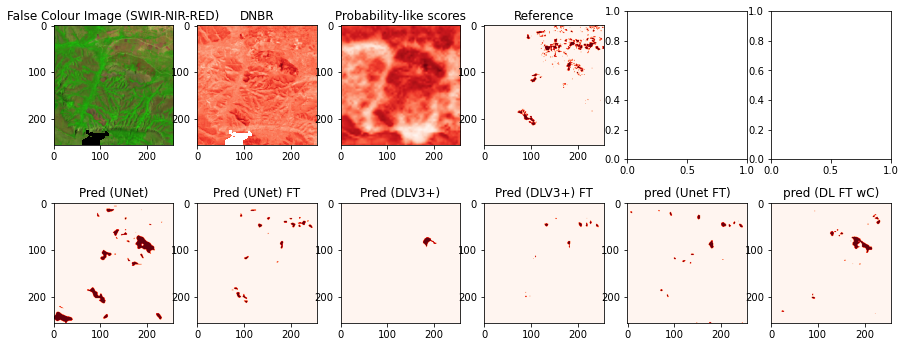

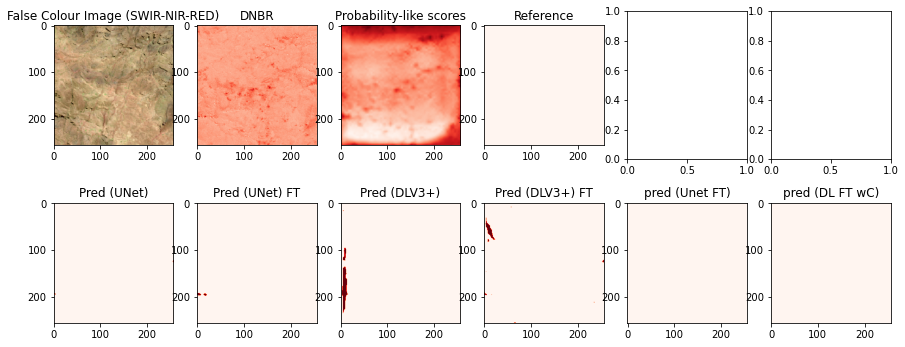

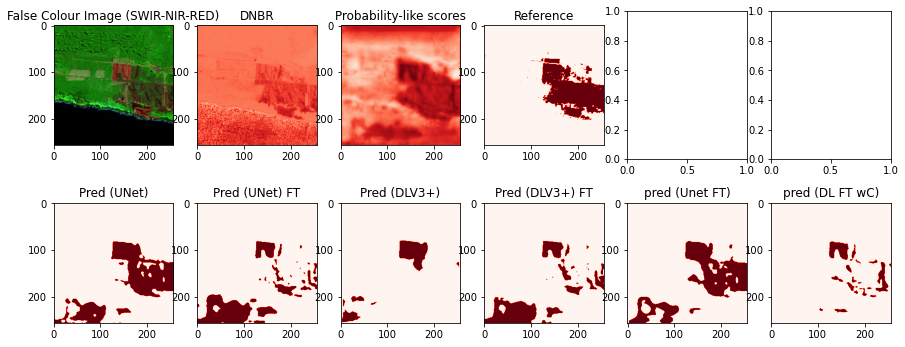

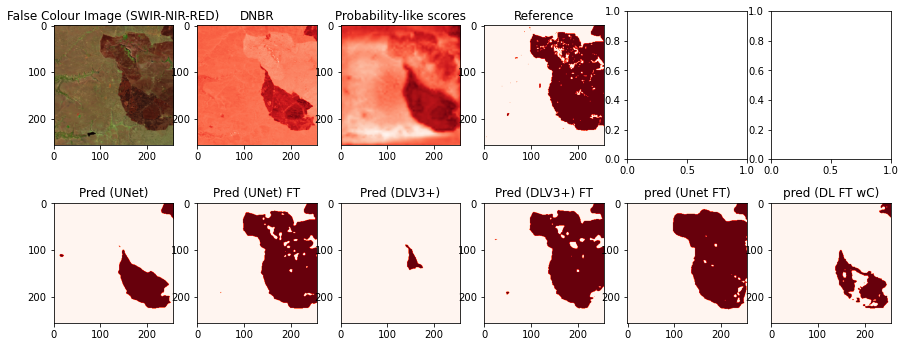

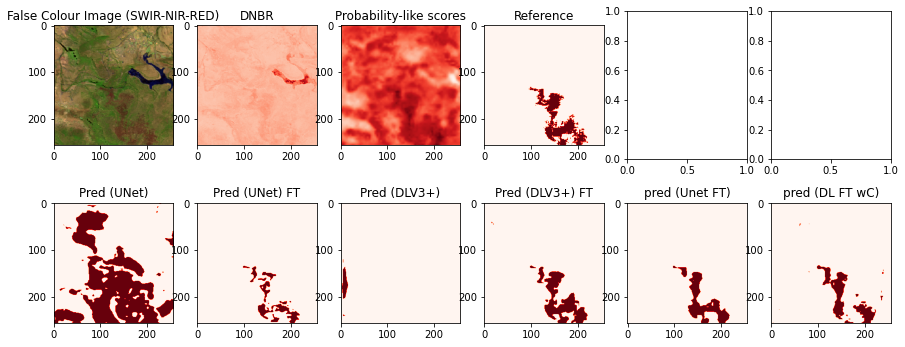

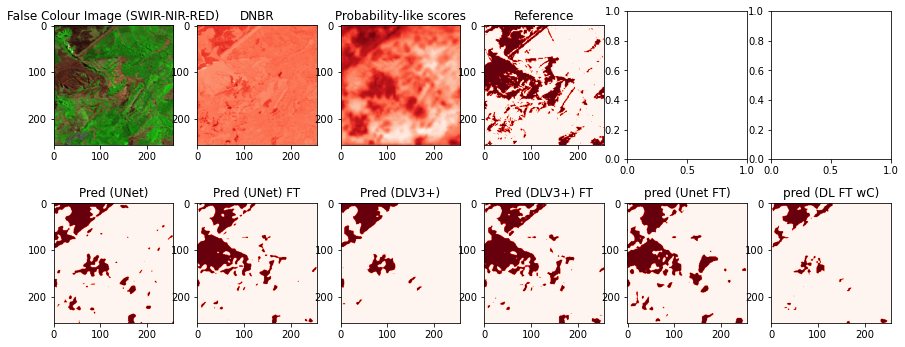

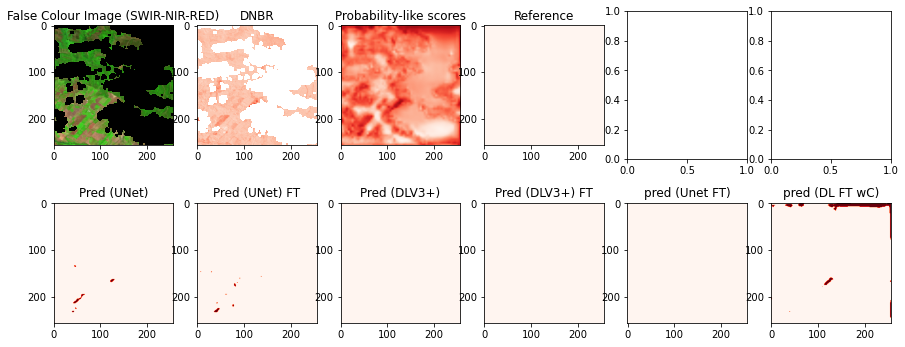

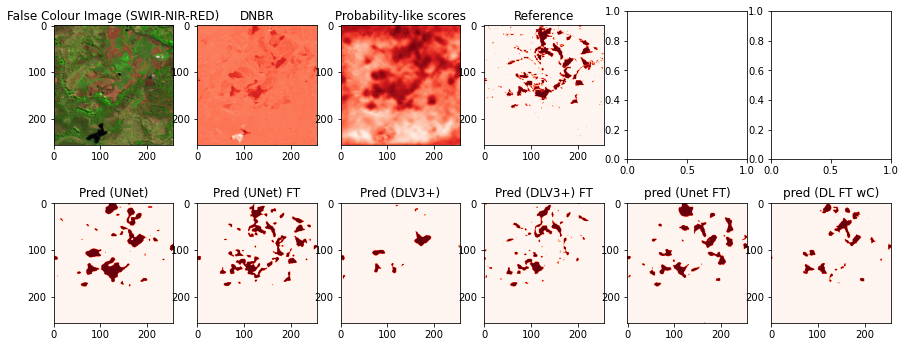

In [13]:
batch = next(iter(valid_dataloader))
inB = torch.nan_to_num(tfms_img(batch)['image']).to(device)
out = model(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outus = modelus(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outdlft = modeldlft(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outdlus = modeldlus(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outnxt = modelnxt(inB)
outnxtft = modelnxtft(inB)
plot_batch_preds(batch)

In [16]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 256, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)


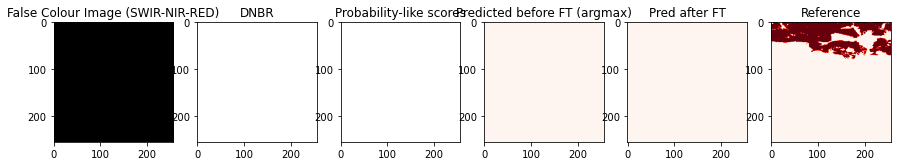

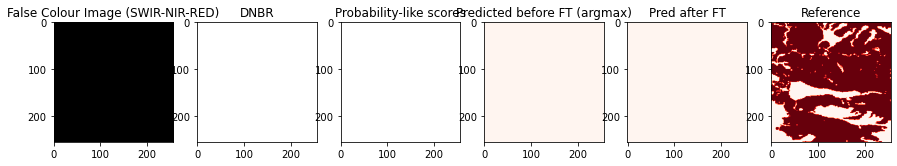

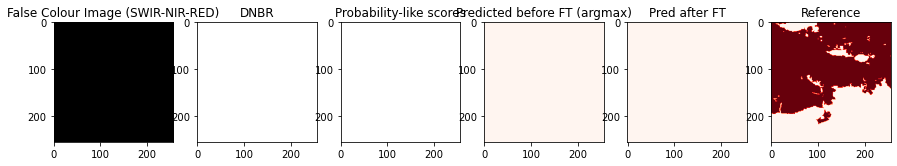

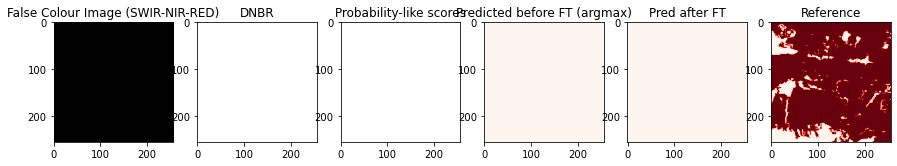

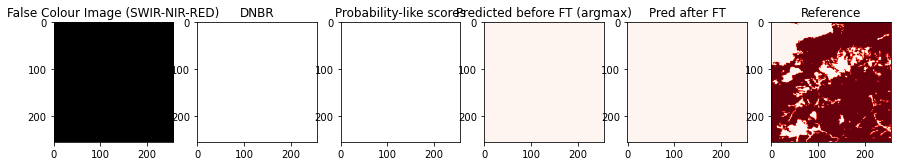

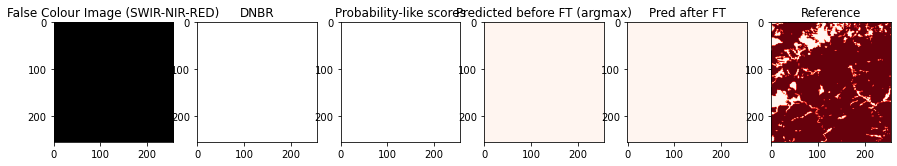

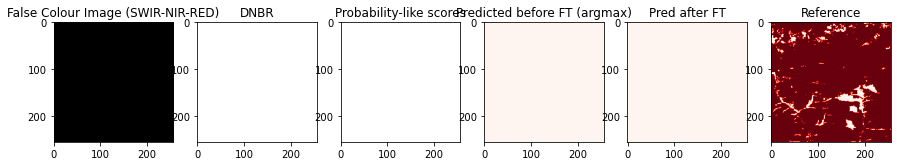

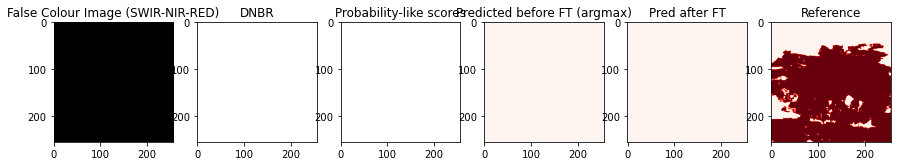

In [19]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 6, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Predicted before FT (argmax)',  'Pred after FT', 'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
                
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(outnxtft[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(outnxt[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        pred_mask = np.argmax(outnxtft[idx].detach().cpu().numpy(), axis=0)
        axs[4].imshow(pred_mask, cmap='Reds')
        axs[4].set_title(labels[4])

        mask = batch['mask'][idx].cpu().numpy()
        # plot the reference mask
        axs[5].imshow(mask.squeeze(), cmap='Reds')
        axs[5].set_title(labels[5])

batch = next(iter(test_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outus = modelus(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outdlft = modeldlft(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outdlus = modeldlus(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outnxt = modelnxt(inB)
outnxtft = modelnxtft(inB)
plot_batch_preds(batch)

# Conformal prediction

In [21]:
# Conformal prediction

# Calibration - compute threshold
# compute adjusted quantile
# for each batch of images and masks, compute the adjusted quantile and append to list
# compute quantile for list

# Inference - compute set lengths and binary image for each class
# binarise probability bands based on threshold. compute sum of binary bands for set length

# Evaluation - compute RCPS, coverage and average set size
# check if the mask values are included in the binary images to compute coverage
# calculate mean of set length bands across all batches for average set size

import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt
import torchseg

device = 'cuda' if torch.cuda.is_available() else 'cpu'

root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2')
assert root.exists()
valid_imgs = RasterDataset(paths=(root/'test\X').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\Y').as_posix(), crs='epsg:4326', res= 0.00025)

valid_dset = valid_imgs & valid_msks

# IMPORTANT
valid_msks.is_image = False
valid_sampler = RandomGeoSampler(valid_imgs, size= 224, length = 78, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)

model = torchseg.DeepLabV3Plus(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    # decoder_channels=(256, 128, 64, 32),
    # head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDL_imgnet_convnextT_20102024.pth")#2909

model.load_state_dict(checkpoint)
model.eval()

# model = torchseg.Unet(
#     encoder_name="convnextv2_tiny",        
#     encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
#     in_channels=14,
#     classes=2,
#     encoder_depth= 4,
#     decoder_channels=(256, 128, 64, 32),
#     head_upsampling=2                      
# ).to(device)

# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUnet_imgnet_convnextT_16102024.pth")#2909

# model.load_state_dict(checkpoint)
# model.eval()

C:\Users\coach\AppData\Local\Temp\ipykernel_24032\3069588403.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fi

DeepLabV3Plus(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(14, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
   

In [ ]:
X = next(iter(valid_dataloader))
outputs = model(torch.nan_to_num(tfms_img(X)['image'].to(device)))

probs = torch.softmax(outputs, dim=1)

# mask is 8, 1, 224, 224
# pred is 8, 2, 224, 224

In [22]:
import torch
import math
import numpy as np
from tqdm.auto import tqdm

# Calibration function to compute adjusted quantile
def compute_adjusted_quantile(n_cal, alpha):
    return 1 - (math.ceil((n_cal + 1) * (1 - alpha)) / n_cal)

# Calibration routine
def calibration(model, cal_loader, n_cal, alpha=0.1):
    adj_quantile = compute_adjusted_quantile(n_cal, alpha)
    print(f'Adjusted quantile: {adj_quantile}')
    
    scores = []
    with torch.no_grad():
        for batch in tqdm(cal_loader):
            X = tfms_img(batch)['image'].to(device)
            y = batch['mask'].type(torch.long).unsqueeze(1).to(device)
            
            # Get model outputs
            outputs = model(torch.nan_to_num(X))
            probs = torch.softmax(outputs, dim=1)
            
            # Select non-conformity scores corresponding to the true labels
            selected_scores = torch.gather(probs, 1, y)  # shape: (8, 1, 224, 244)
            
            # Calculate quantile on the flattened selected scores
            qhat = torch.quantile(selected_scores.flatten(), adj_quantile)
            # print(f"qhat for batch is {qhat}")
            
            # Store qhat in scores
            scores.append(qhat.cpu().numpy())  # move to CPU and convert to NumPy
            
    # Concatenate scores into a single array
    scores = np.array(scores)
    
    # Compute the final threshold using the adjusted quantile
    threshold = np.quantile(scores, adj_quantile)
    return threshold

# Inference
def inference(model, batch, threshold):
    
    with torch.no_grad():
        X = tfms_img(batch)['image'].type(torch.float32).to(device)
        outputs = model(torch.nan_to_num(X))
        probs = torch.softmax(outputs, dim=1)
        binary = (probs >= threshold).float()
        set_length = binary.sum(dim=1)
        batch['probability'] = outputs
        batch['pred'] = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        batch['setLength'] = set_length
        batch['binary'] = binary
    return batch


# Evaluation
def evaluate(model, dataloader, threshold):
    coverages = []
    set_size = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            X = tfms_img(batch)['image'].to(device)
            y = batch['mask'].type(torch.long).unsqueeze(1).to(device)
                
            # Get model outputs
            outputs = model(torch.nan_to_num(X))
            probs = torch.softmax(outputs, dim=1)
            binary = (probs >= threshold).float()
            set_length = binary.sum(dim=1)

            coverage =  torch.gather(binary, 1, y).mean()
            coverages.append(coverage.cpu().numpy())
            avg_set_size = set_length.float().mean()
            set_size.append(avg_set_size.cpu().numpy())

    # Concatenate scores into a single array
    marginal_coverage = np.array(coverages).mean()
    average_set_sizes = np.array(set_size).mean()
    
    return {'coverage':marginal_coverage, 'set_size':average_set_sizes}

In [23]:
alpha = 0.95
compute_adjusted_quantile(2228224, 0.1)
threshold = calibration(model = model, cal_loader = valid_dataloader, n_cal = 2228224, alpha = 0.1)
print(f"final qhat: {threshold}")
eval_metrics = evaluate(model, valid_dataloader, threshold)
print(eval_metrics)

Adjusted quantile: 0.09999937169692097


  0%|          | 0/10 [00:00<?, ?it/s]

final qhat: 0.7120361408664233


  0%|          | 0/10 [00:00<?, ?it/s]

{'coverage': 0.9087696, 'set_size': 0.9770237}


In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 6, figsize=(20, 5))

        # Define the labels
        labels = ['FCI (SWIR-NIR-Red)', 'Mask', 'Uncertainty: Set length', 'Sets w/ BA', 'Prob', 'Pred']

        img = batch['image'][idx,[8, 6, 2],:,:].cpu().numpy()*2                
        fci = img.transpose((1, 2, 0))
        
        # plot the image
        axs[0].imshow(fci.squeeze())
        axs[0].set_title(labels[0])

        # plot the mask
        axs[1].imshow(batch['mask'][idx,:,:].cpu().numpy().squeeze(), cmap='Reds')
        axs[1].set_title(labels[1])

        # Create a discrete palette for set length
        cmap = ListedColormap(['red', 'orange', 'yellow'])
        axs[2].imshow(batch['setLength'][idx,:,:].cpu().numpy(), cmap=cmap, vmin=0, vmax=2)
        axs[2].set_title(labels[2])

        # Add a legend for the discrete palette
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=2), cmap=cmap), ax=axs[2], shrink=0.5)
        cbar.set_ticks([0.33, 1, 1.67])
        cbar.set_ticklabels(['0', '1', '2'])

        # plot the predicted mask
        axs[3].imshow(batch['binary'][idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[3].set_title(labels[3])

        # plot the probability band
        axs[4].imshow(batch['probability'][idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[4].set_title(labels[4])

        axs[5].imshow(batch['pred'][idx], cmap='Reds')
        axs[5].set_title(labels[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


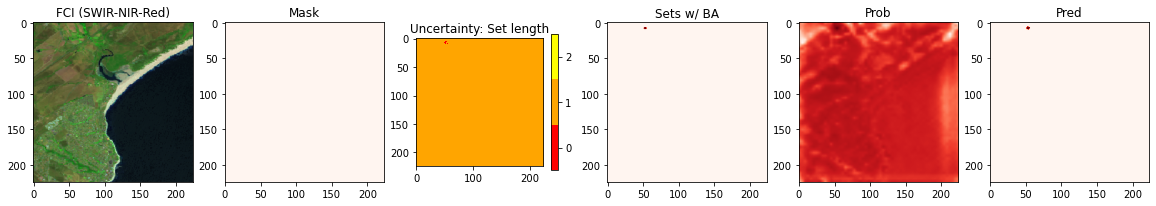

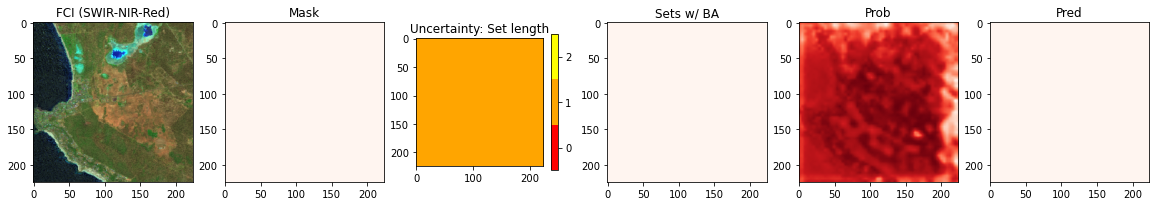

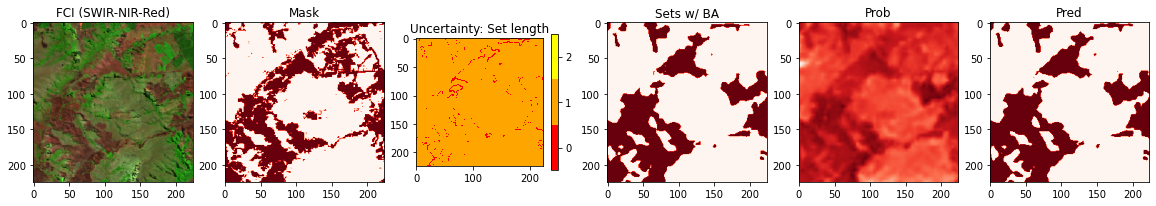

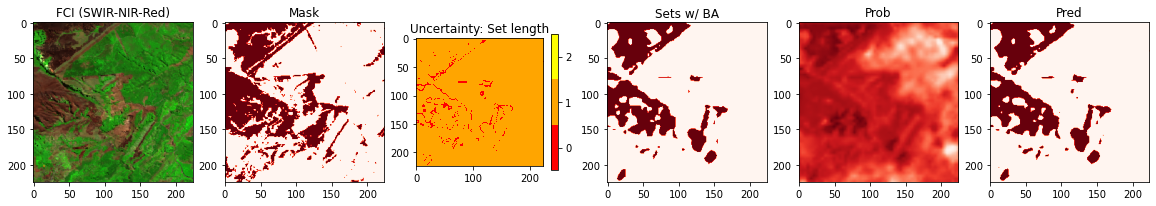

c:\ProgramData\Anaconda3\envs\erthy\lib\site-packages\matplotlib\cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


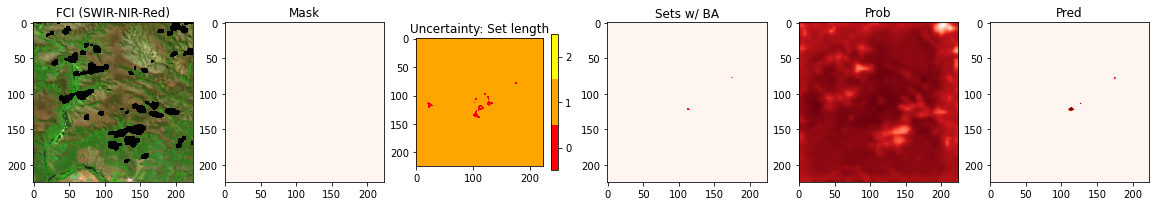

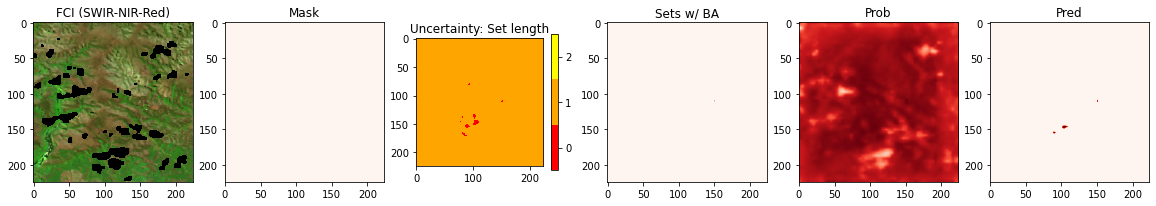

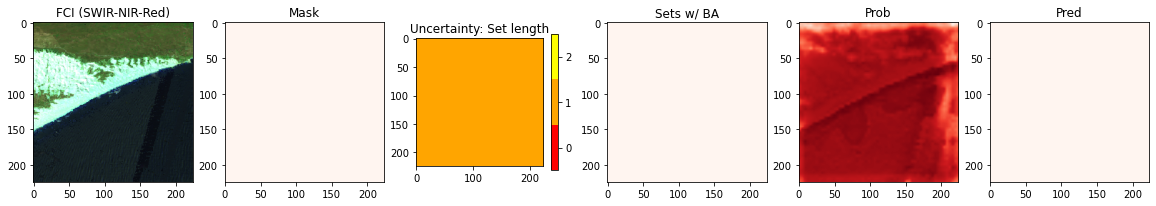

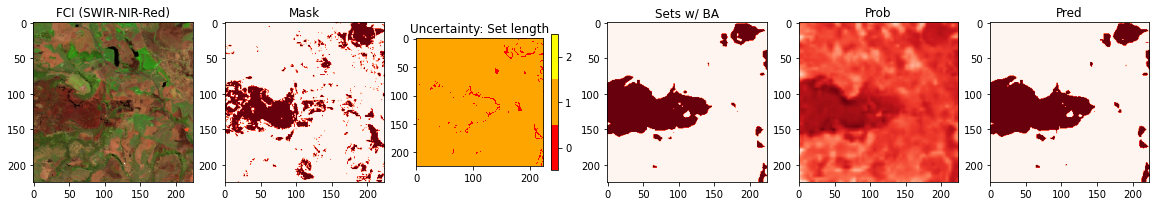

In [27]:
batch = next(iter(valid_dataloader))
uq = inference(model, batch, threshold)
plot_batch_preds(uq)

In [120]:
from torchcp.classification.scores import THR, SAPS
from torchcp.classification.predictors import SplitPredictor

# Preparing a calibration data and a test data.
# cal_dataloader = ...
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

# Preparing a pytorch model
modeldlft = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDLV3P_12092024.pth")
modeldlft.load_state_dict(checkpoint)
modeldlft.eval()

# Options of score function: THR, APS, SAPS, RAPS
# Define a conformal prediction algorithm. Optional: SplitPredictor, ClusteredPredictor, ClassWisePredictor
predictor = SplitPredictor(score_function=THR(), model=modeldlft)

# Calibrating the predictor with significance level as 0.1
predictor.calibrate(test_dataloader, alpha=0.1)

#########################################
# Predicting for test instances
########################################
# test_instances = ...
# predict_sets = predictor.predict(test_instances)
# print(predict_sets)

#########################################
# Evaluating the coverage rate and average set size on a given dataset.
########################################
# result_dict = predictor.evaluate(test_dataloader)
# print(result_dict["Coverage_rate"], result_dict["Average_size"])


AttributeError: 'list' object has no attribute 'to'

In [1]:
import torch
from scipy.optimize import brentq

def false_negative_rate(pred_masks, true_masks):
    # Ensure the inputs are binary tensors
    pred_masks = pred_masks.float()  # Convert to float for arithmetic operations
    true_masks = true_masks.float()
    
    # True positives: pixels correctly predicted as part of the object
    true_positives = (pred_masks * true_masks).sum(dim=[1, 2])
    
    # Total object pixels in the ground truth (true positives + false negatives)
    total_object_pixels = true_masks.sum(dim=[1, 2])
    
    # True Positive Rate (TPR) = true_positives / total_object_pixels
    tpr = true_positives / total_object_pixels
    
    # False Negative Rate (FNR) = 1 - TPR
    fnr = 1 - tpr
    
    # Return the average FNR across the batch
    return fnr.mean()

# Helper function to compute FNR for a given threshold
def lamhat_threshold(lam, calibration_loader, n, alpha, device):
    total_fnr = 0.0
    num_batches = 0
    
    for cal_sgmd, cal_gt_masks in calibration_loader:
        # Move data to the appropriate device (CPU/GPU)
        cal_sgmd = cal_sgmd.to(device)
        cal_gt_masks = cal_gt_masks.to(device)
        
        # Apply the threshold to the sigmoid outputs
        pred_masks = cal_sgmd >= lam
        
        # Calculate FNR for the current batch
        batch_fnr = false_negative_rate(pred_masks, cal_gt_masks)
        total_fnr += batch_fnr.item()
        num_batches += 1
    
    # Average FNR across all batches
    avg_fnr = total_fnr / num_batches
    
    # Return the difference between FNR and the target FNR
    return avg_fnr - ((n + 1) / n * alpha - 1 / n)

def find_lamhat(calibration_loader, n, alpha, device='cpu'):
    # Define the function to optimize (find the root)
    def threshold_func(lam):
        return lamhat_threshold(lam, calibration_loader, n, alpha, device)
    
    # Use Brent's method to find the optimal threshold `lamhat`
    lamhat = brentq(threshold_func, 0, 1)
    
    return lamhat

def predict_masks(val_loader, lamhat, device='cpu'):
    predicted_masks_list = []
    
    for val_sgmd, _ in val_loader:
        # Move data to the appropriate device
        val_sgmd = val_sgmd.to(device)
        
        # Apply the threshold to sigmoid outputs
        predicted_masks = val_sgmd >= lamhat
        
        # Collect the predicted masks
        predicted_masks_list.append(predicted_masks.cpu())  # Move back to CPU if needed
    
    # Concatenate all predicted masks into a single tensor
    return torch.cat(predicted_masks_list, dim=0)


In [ ]:
# Preparing a calibration data and a test data.
# cal_dataloader = ...
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

# Preparing a pytorch model
modeldlft = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDLV3P_12092024.pth")
modeldlft.load_state_dict(checkpoint)
modeldlft.eval()

In [ ]:
# Example setup for calibration and validation data loaders

# Number of calibration samples and desired alpha level
n = 10
alpha = 0.05

# Device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Find the optimal threshold `lamhat`
lamhat = find_lamhat(test_dataloader, n, alpha, device)

# Use `lamhat` to generate predictions for the validation set
predicted_masks = predict_masks(test_dataloader, lamhat, device)


In [ ]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from scipy.optimize import brentq

# UNet model loading
def load_trained_unet_model(model_path, device='cpu'):
    model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_weights= None, classes=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

from torch.nn.functional import softmax

valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)
batch = next(iter(valid_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB)
outus = modelus(inB)
outdlft = modeldlft(inB)
outdlus = modeldlus(inB)
# test the functions
x = out[0, :, 0, 0]  # single pixel value

print("Softmax:", softmax(x, dim=0))
print(softmax(out, dim=1)[0, :, 0, 0])

# Sigmoid outputs
def get_softmax_outputs(model, data_loader, device='cpu'):
    all_softmax_outputs = []
    all_gt_masks = []
    
    with torch.no_grad():
        for images, gt_masks in data_loader:
            images = images.to(device)
            gt_masks = gt_masks.to(device)
            logits = model(images)
            sigmoids = torch.sigmoid(logits)
            all_softmax_outputs.append(sigmoids.cpu())
            all_gt_masks.append(gt_masks.cpu())
    return torch.cat(all_softmax_outputs, dim=0), torch.cat(all_gt_masks, dim=0)

# Define false negative rate calculation
def false_negative_rate(pred_masks, true_masks):
    pred_masks = pred_masks.float()
    true_masks = true_masks.float()
    true_positives = (pred_masks * true_masks).sum(dim=[1, 2])
    total_object_pixels = true_masks.sum(dim=[1, 2])
    tpr = true_positives / total_object_pixels
    fnr = 1 - tpr
    return fnr.mean()

# Find lamhat using calibration set
def lamhat_threshold(lam, calibration_loader, n, alpha, device):
    total_fnr = 0.0
    num_batches = 0
    for cal_sgmd, cal_gt_masks in calibration_loader:
        cal_sgmd = cal_sgmd.to(device)
        cal_gt_masks = cal_gt_masks.to(device)
        pred_masks = cal_sgmd >= lam
        batch_fnr = false_negative_rate(pred_masks, cal_gt_masks)
        total_fnr += batch_fnr.item()
        num_batches += 1
    avg_fnr = total_fnr / num_batches
    return avg_fnr - ((n + 1) / n * alpha - 1 / n)

def find_lamhat(calibration_loader, n, alpha, device='cpu'):
    def threshold_func(lam):
        return lamhat_threshold(lam, calibration_loader, n, alpha, device)
    lamhat = brentq(threshold_func, 0, 1)
    return lamhat

# Predict masks for validation set
def predict_masks(val_loader, lamhat, device='cpu'):
    predicted_masks_list = []
    for val_sgmd, _ in val_loader:
        val_sgmd = val_sgmd.to(device)
        predicted_masks = val_sgmd >= lamhat
        predicted_masks_list.append(predicted_masks.cpu())
    return torch.cat(predicted_masks_list, dim=0)

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_trained_unet_model(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDLV3P_12092024.pth", device)

root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

# Calculate sigmoid outputs
cal_sgmd, cal_gt_masks = get_sigmoid_outputs(model, calibration_loader, device)
val_sgmd, val_gt_masks = get_sigmoid_outputs(model, val_loader, device)

# Find optimal threshold lamhat
n = len(calibration_loader.dataset)
alpha = 0.05
lamhat = find_lamhat(calibration_loader, n, alpha, device)

# Apply threshold to validation set
predicted_masks = predict_masks(val_loader, lamhat, device)
